<a href="https://colab.research.google.com/github/csralvall/online_game_toxicity/blob/main/clustering_bow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import utility functions

In [1]:
from IPython.display import clear_output

### Install dependencies

In [2]:
!pip install -U kaggle pip setuptools wheel pandas sklearn numpy wget mr4mp
clear_output()

### Import libraries

In [3]:
from google.colab import drive, files
import pandas as pd
import spacy
import numpy as np
import pickle
import mr4mp
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from timeit import default_timer
from collections import Counter

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Mount storage

In [5]:
# mount google drive unit to save computationally expensive results
drive.mount('/content/drive')

Mounted at /content/drive


### Get subset of whole dataset

In [14]:
# english chats from original dataset with anotations
eng_annotated = '/content/drive/MyDrive/nlp/dota2_chat_eng_annotated.csv'
df_test = pd.read_csv(eng_annotated)[:10000]

### Get bad word list from memory

In [ ]:
# get downloaded bad word list
word_list = "/content/drive/MyDrive/nlp/bad_words.txt"
# use set for fast queries
bad_words = set(line.strip() for line in open(word_list, 'r'))
# add new bad words
bad_words.update(['noob', 'noobs', 'stfu', 'fukign', 'fuking', 'fukin', 'nooob'])
bad_dict = dict.fromkeys(bad_words, 0)

### Create Bag of Words (BOW)

In [58]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [ ]:
# function to transform chats in sets of words
def chat_to_set(chat: [str]) -> {str}:
    return set(chat.split())

# function to join all chat sets in one big set
def join_chat_sets(chat: {str},bag: {str}) -> {str}:
    return bag.union(chat)

In [59]:
# from cleaned english chats get all of them without nan values
chats = df_test[['tokens']].dropna().astype(str).values

In [60]:
chats = flatten(chats)

In [ ]:
# use map reduce model to create the Bag of Words (BOW)
start = default_timer()
pool = mr4mp.pool(10) # roughly 1hs with gpu with full eng dataset
set_of_words = pool.mapreduce(chat_to_set, join_chat_sets, chats)
pool.close()
bag_of_words = dict.fromkeys(set_of_words, 0)
print("Finished in " + str(default_timer()-start) + "s using " + str(len(pool)) + " process(es).")

Finished in 0.27319918500000995s using 10 process(es).


In [ ]:
# save bag of words in drive (very expensive to compute)
# use when running code with full dataset
with open('/content/drive/MyDrive/nlp/bag_of_words.pkl', 'wb') as dict_file:
    pickle.dump(bag_of_words, dict_file)
    dict_file.close()

#### Clustering utils

In [ ]:
def get_bad_vec(lexicon, chat_words):
    for word in chat_words:
        if word in lexicon:
            bad_dict[word] += 1

    bad_vec = np.fromiter(bad_dict.values(), dtype=int)
    
    return bad_vec

In [ ]:
def get_bow_vec(bow, chat_words):
    for word in word_list:
        if word in bow:
            bow[word] += 1

    bow_vec = np.fromiter(bow.values(), dtype=int)

    return bow_vec

In [ ]:
intensity = df_test[['intensity']].copy()

### Create bow vectors for clustering

In [ ]:
for idx, chat in enumerate(chats):
    bow = dict.fromkeys(bag_of_words, 0)
    lexicon = dict.fromkeys(bad_words, 0)
    chat_intensity = intensity.loc[idx]
    chat_words = chat.split()
    bad_vec = get_bad_vec(lexicon, chat_words)
    bow_vec = get_bow_vec(bow, chat_words)
    bow_bad_int_vec = np.hstack((bow_vec, bad_vec, chat_intensity)).ravel()
    if idx == 0:
        bow_serie = bow_bad_int_vec
    else:
        bow_serie = np.concatenate((bow_serie, bow_bad_int_vec))


### Reshape data

In [ ]:
bow_ncolumns = len(set_of_words) + len(bad_words) + 1
bow_serie = bow_serie.astype('float').reshape((-1, bow_ncolumns))
bow_matrix = bow_serie[~np.isnan(bow_serie)].reshape((-1, bow_ncolumns))

### Matrix reduction

In [ ]:
def reduce_matrix(matrix: np.ndarray, *, variance_treshold: float):
    print(f'INPUT SHAPE: {matrix.shape}')
    # reduce all vectors to [0, 1] space
    normalized_matrix = normalize(matrix, axis=1)
    # compute variances in each row
    matrix_variances = np.var(matrix, axis=0)
    # create mask for features with high correlation (low variance)
    bool_mask = np.where(matrix_variances < variance_treshold)
    # filter features with high correlation (variance under treshold)
    raked_matrix = np.delete(normalized_matrix, bool_mask, axis=1)
    print(f'OUTPUT SHAPE: {raked_matrix.shape}')
    return raked_matrix

### Reduce matrix

In [ ]:
bow_reduced = reduce_matrix(bow_matrix, variance_treshold=0.0001)

INPUT SHAPE: (8157, 5228)
OUTPUT SHAPE: (8157, 141)


### Save matrix

In [ ]:
with open('/content/drive/MyDrive/nlp/bow_serie_10000.npy', 'wb') as output_file:
    np.save(output_file, bow_matrix)

### Load matrix from storage

In [36]:
bow_reduced = np.load('/content/drive/MyDrive/nlp/bow_serie_10000.npy')

#### Clustering

In [37]:
def generate_clusters(
    matrix: np.ndarray,
    n_clusters: int
) -> KMeans:
    # generate word clusters using the KMeans algorithm.
    print("\nClustering started")
    # Instantiate KMeans clusterer for n_clusters
    km_model = KMeans(n_clusters=n_clusters, random_state=3)
    # create clusters
    km_model.fit(matrix)
    print("Clustering finished")
    return km_model

### Create clusters

In [38]:
bow_clusters = generate_clusters(bow_reduced, 50)


Clustering started
Clustering finished


### Cluster utility functions

In [39]:
def display_summary(clusters: KMeans):
    cluster_count = Counter(sorted(clusters.labels_))
    for cluster in cluster_count:
        print ("Cluster#", cluster," - Total words:", cluster_count[cluster])

In [40]:
def annotate_dataframe(clusters: KMeans, df: pd.DataFrame, col_name: str):
    cluster_count = Counter(sorted(clusters.labels_))
    #sort cluster centers by proximity to centroid
    order_centroids = clusters.cluster_centers_.argsort()[:, ::-1] 

    clusters_df = np.zeros(len(df))
    
    for cluster_idx in cluster_count:
        # get words inside each cluster
        cluster_words = np.where(clusters.labels_ == cluster_idx)[0]
        # anotate all chats in cluster
        for idx in cluster_words:
            clusters_df[idx] = int(cluster_idx)

    df[col_name] = clusters_df

### Show info about clusters

In [41]:
display_summary(bow_clusters)

Cluster# 0  - Total words: 234
Cluster# 1  - Total words: 144
Cluster# 2  - Total words: 128
Cluster# 3  - Total words: 190
Cluster# 4  - Total words: 156
Cluster# 5  - Total words: 236
Cluster# 6  - Total words: 225
Cluster# 7  - Total words: 204
Cluster# 8  - Total words: 108
Cluster# 9  - Total words: 183
Cluster# 10  - Total words: 186
Cluster# 11  - Total words: 227
Cluster# 12  - Total words: 211
Cluster# 13  - Total words: 150
Cluster# 14  - Total words: 210
Cluster# 15  - Total words: 164
Cluster# 16  - Total words: 90
Cluster# 17  - Total words: 215
Cluster# 18  - Total words: 126
Cluster# 19  - Total words: 148
Cluster# 20  - Total words: 134
Cluster# 21  - Total words: 188
Cluster# 22  - Total words: 210
Cluster# 23  - Total words: 224
Cluster# 24  - Total words: 137
Cluster# 25  - Total words: 144
Cluster# 26  - Total words: 211
Cluster# 27  - Total words: 126
Cluster# 28  - Total words: 206
Cluster# 29  - Total words: 201
Cluster# 30  - Total words: 141
Cluster# 31  - Tota

In [42]:
df_test = df_test.copy()

### Annotate cluster for each row in dataframe

In [43]:
annotate_dataframe(bow_clusters, df_test, 'bow_clusters')

In [44]:
df_test.to_csv(f'/content/drive/MyDrive/nlp/bow_clusters_df.csv', index=False)

### Load Bag-of-Words clusters

In [45]:
df_test = pd.read_csv('/content/drive/MyDrive/nlp/bow_clusters_df.csv')

### Explore results

In [46]:
bow_group = df_test.groupby('bow_clusters')

#### Get toxicity score for each cluster

In [47]:
bow_score = (bow_group['toxicity'].sum() / bow_group.size())
bow_scored = pd.DataFrame({'score': bow_score.values, 'size': bow_group.size()})
bow_scored = bow_scored[bow_scored['score'] > 0.14]
bow_scored = bow_scored.sort_values(by=['score', 'size'], ascending=[False, False])
top_toxic_clusters = bow_scored.index.to_list()
bow_scored

,score,size
bow_clusters,,
43.0,0.190476,63
22.0,0.185714,210
2.0,0.164062,128
34.0,0.163636,165
11.0,0.158590,227
10.0,0.155914,186
8.0,0.148148,108
38.0,0.148148,81


#### Explore clusters

In [48]:
bow_group.get_group(43)[['match','text']]

,match,text
6657,1050,U KNOW Arise
6658,1050,i thouht i was playing against him
6659,1050,Stupid
6660,1050,nvm
6661,1050,ulti was cd
6662,1050,lol
6663,1050,this arise ..
6664,1050,THIS ARISE
6665,1050,yea
6666,1050,we cant win 4v5


In [49]:
bow_group.get_group(22)[['match','text']]

,match,text
687,107,dun use small id to lie other ppl
688,107,u still injoler
689,107,me?
690,107,lol
691,107,take so long time to end
692,107,noob
693,107,Lol
694,107,i fuck your mum
695,107,she so hot
696,107,end pls


In [50]:
bow_group.get_group(2)[['match','text']]

,match,text
7163,1124,WOW
7164,1124,x4
7165,1124,sf shit
7166,1124,rly
7167,1124,Bkb
7168,1124,EZ CD
7169,1124,what invo
7170,1124,sf
7171,1125,he no regen
7172,1125,No idea wtf is going


In [51]:
bow_group.get_group(34)[['match','text']]

,match,text
4056,583,lmao
4057,583,saf
4058,583,very sad
4059,583,XD
4060,583,radiant team
4061,583,"meh, free lanes for middle and top = basura"
4062,583,wtfd
4063,583,shameful display
4064,583,report allison
4065,583,garbage


In [52]:
bow_group.get_group(11)[['match','text']]

,match,text
1535,215,and Io just doenst available on mid cuz like that
1536,215,ruins every single game hes in
1537,215,this qop is just ruining the moment
1538,215,i had him muted
1539,215,he just dont realize omni is the worst 5 u can...
1540,215,what did he say?
1541,215,nothing
1542,215,gg this omni watches too much fucking slacks
1543,215,gl next
1544,216,my fucking tide


In [53]:
bow_group.get_group(10)[['match','text']]

,match,text
501,80,commend
502,81,worth?
503,81,gg wp
504,82,papakakaka
505,82,just
506,82,passed
507,82,then i ded
508,82,ok
509,82,fair play
510,82,called storm spirit m9


In [54]:
bow_group.get_group(8)[['match','text']]

,match,text
3555,516,yea will see
3556,516,sure
3557,516,told u
3558,516,CUTE LC
3559,516,really
3560,516,nc armlet toggle
3561,516,Haha
3562,516,fail sf
3563,516,fk u nooob
3564,516,wew


In [55]:
bow_group.get_group(38)[['match','text']]

,match,text
7387,1140,WHY ME?
7388,1140,LOL
7389,1140,GG WP
7390,1141,teammates killed me
7391,1141,they kept calling me a retard
7392,1141,same here
7393,1141,cleaved off creeps and killed LD
7394,1141,gg wp
7395,1144,ff
7396,1145,nice lags


### Reduce dimensionality to display data

In [56]:
# use TSNE to reduce dimensionality of data
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(bow_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### Display data without clusters

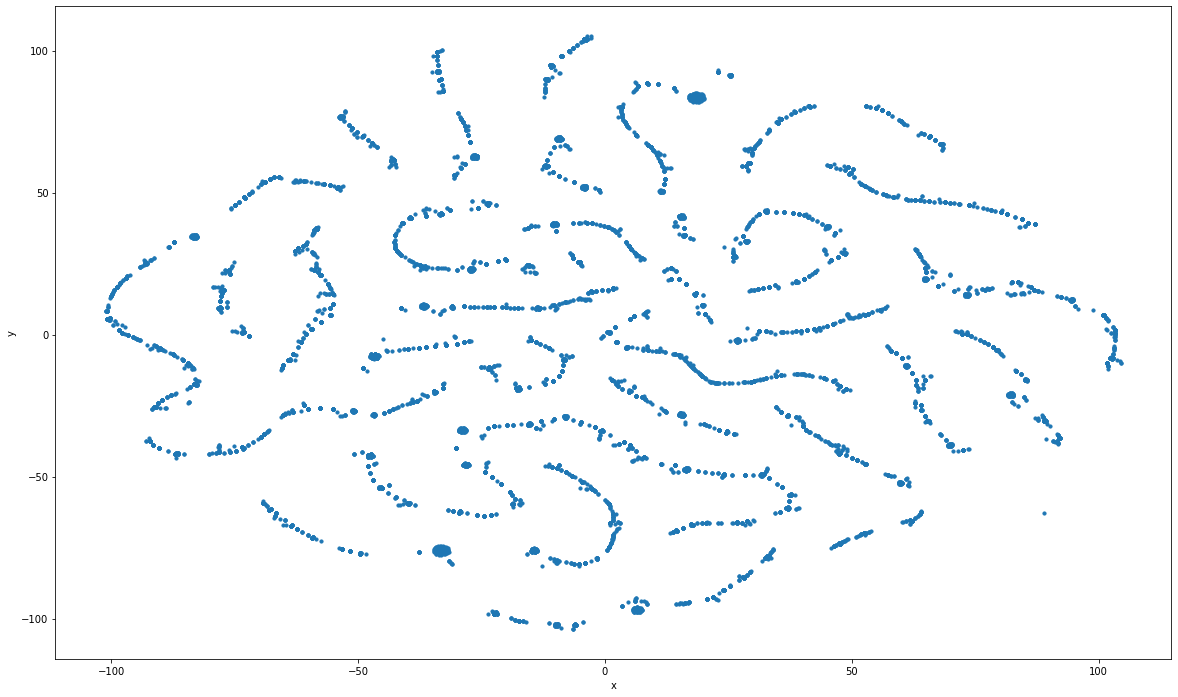

In [61]:
pointsspacy = pd.DataFrame(
    [(chat, coord[0], coord[1]) for (chat, coord) in zip(chats, matrix_dicc2d)],
    columns=["word", "x", "y"]
)
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

### Display clusters and clusters with biggest proportion of toxic words

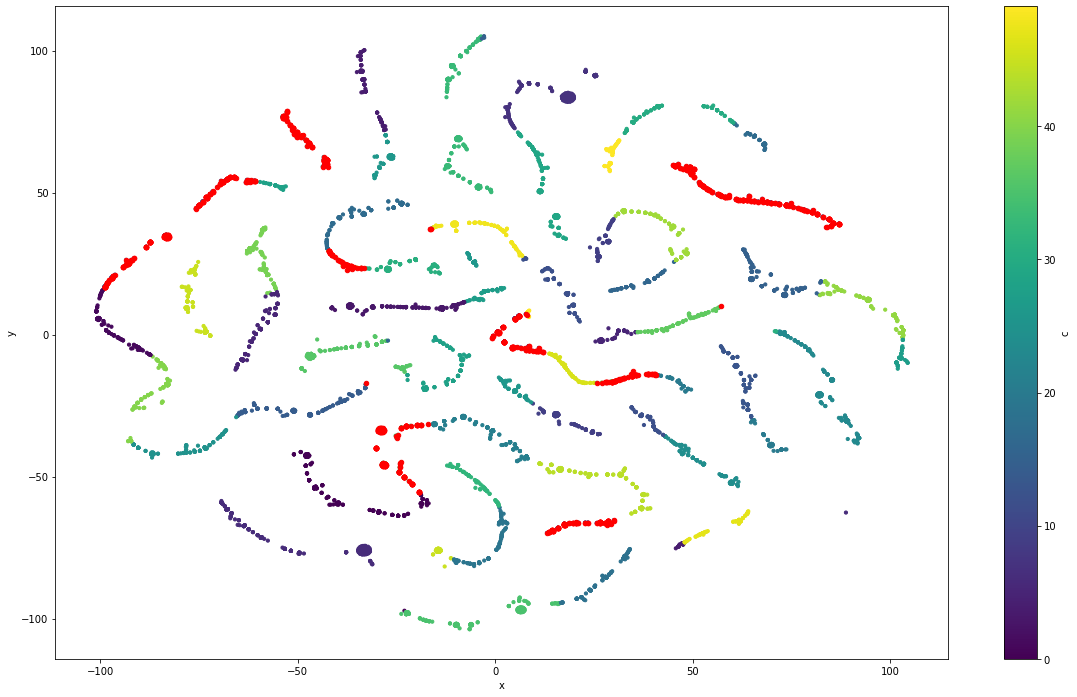

In [63]:
fig, ax = plt.subplots()
pointscluster = pd.DataFrame(
    [(chat, coord[0], coord[1], cluster) for (chat, coord, cluster) in zip(df_test['clean'], matrix_dicc2d, df_test['bow_clusters']) ],
    columns=["word", "x", "y", "c"]
)
pointscluster.plot(ax=ax, kind='scatter', x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))
toxic_clusters = pd.DataFrame(
    [(coord[0], coord[1]) for (coord, cluster) in zip(matrix_dicc2d, df_test['bow_clusters']) if cluster in top_toxic_clusters ],
    columns=["x", "y"]
)
toxic_clusters.plot(ax=ax, kind='scatter', x='x', y='y', color='red')
plt.show()